## Setup

Please run the cells below to install the necessary dependencies.


In [1]:
%%capture
!git clone https://github.com/AI4Bharat/IndicTrans2.git

In [2]:
%%capture
%cd /content/IndicTrans2/huggingface_interface

In [3]:
%%capture
!python3 -m pip install nltk sacremoses pandas regex mock transformers>=4.33.2 mosestokenizer
!python3 -c "import nltk; nltk.download('punkt')"
!python3 -m pip install bitsandbytes scipy accelerate datasets
!python3 -m pip install sentencepiece

In [1]:
!pip install git+https://github.com/VarunGumma/IndicTransToolkit.git

  Cloning https://github.com/VarunGumma/IndicTransToolkit.git to /tmp/pip-req-build-ay_6ivti
  Running command git clone --filter=blob:none --quiet https://github.com/VarunGumma/IndicTransToolkit.git /tmp/pip-req-build-ay_6ivti
  Resolved https://github.com/VarunGumma/IndicTransToolkit.git to commit 0c607654e8b6cce897a32039df79018a1daff4e2
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/VarunGumma/indic_nlp_library to /tmp/pip-install-r3k0mz_6/indic-nlp-library-it2_e5fb199e33024ac9933b5f7706d617e0
  Running command git clone --filter=blob:none --quiet https://github.com/VarunGumma/indic_nlp_library /tmp/pip-install-r3k0mz_6/indic-nlp-library-it2_e5fb199e33024ac9933b5f7706d617e0
  Resolved https://github.com/VarunGumma/indic_nlp_library to commit 601521e05ed0ed8f2165ac317a47d186e25b6f0d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8

**IMPORTANT : Restart your run-time first and then run the cells below.**

In [2]:
import torch
import numpy as np
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig, AutoTokenizer
from IndicTransToolkit import IndicProcessor
from IndicTransToolkit import IndicEvaluator
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine

BATCH_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None

In [18]:
def initialize_model_and_tokenizer(model_path, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        model_path,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model


def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip):
    translations = []
    for i in range(0, len(input_sentences), BATCH_SIZE):
        batch = input_sentences[i : i + BATCH_SIZE]

        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)

        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)

        # Generate translations using the model
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                min_length=0,
                max_length=256,
                do_sample=True,
                top_k=40,
                top_p=0.9,
                temperature = 0.75,
                num_return_sequences=1,
            )

        # Decode the generated tokens into text

        with tokenizer.as_target_tokenizer():
            generated_tokens = tokenizer.batch_decode(
                generated_tokens.detach().cpu().tolist(),
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # Postprocess the translations, including entity replacement
        translations += ip.postprocess_batch(generated_tokens, lang=tgt_lang)

        del inputs
        torch.cuda.empty_cache()

    return translations

def evaluate_bleu(lang, pred, ref):
  evaluator = IndicEvaluator()
  scores = evaluator.evaluate(tgt_lang=lang, preds=pred, refs=ref)
  return round(float(scores['bleu']['score']/100),3)

def cosine_similarity(original, translated):
    vectorizer = TfidfVectorizer().fit([original, translated])
    vectors = vectorizer.transform([original, translated]).toarray()
    return 1 - cosine(vectors[0], vectors[1])

In [20]:
original_sents = [
    "When I will grow up, I will be a doctor.",
    "They have many pets because they are rich and don't have any kids.",
    "I can't stand the smell of garbage.",
    "She is very hardworking and intelligent, which is why she got all the good marks.",
    "We read a new book last week, which was very inspiring.",
    "If you had met me at that time, we would have gone out to eat.",
    "She went to the market with her sister to buy a new sari.",
    "Raj told me that he is going to his grandmother's house next month.",
    "All the kids were having fun at the party and were eating lots of sweets.",
    "My friend has invited me to his birthday party, and I will give him a gift."]

num_iterations = 20

### English and Assamese Translations


In [21]:
en_indic_model_path = "ai4bharat/indictrans2-en-indic-1B"
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_model_path, quantization)

indic_en_model_path = "ai4bharat/indictrans2-indic-en-1B"
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_model_path, quantization)

ip = IndicProcessor(inference=True)

en_sents = original_sents.copy()
as_bleu_scores = []
as_similarity_values = []

for iteration in range(num_iterations):
    print("Sentences getting translated:", en_sents)
    print()
    print(f"Iteration {iteration + 1}:")

    # English to Assamese
    src_lang, tgt_lang = "eng_Latn", "asm_Beng"
    as_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

    # Translate back from Assamese to English
    src_lang, tgt_lang = "asm_Beng", "eng_Latn"
    en_translations = batch_translate(as_translations, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)

    #  BLEU score
    bleu_score = evaluate_bleu(tgt_lang, en_translations, original_sents)
    as_bleu_scores.append(bleu_score)
    print(f"BLEU Score: {bleu_score}")

    # Cosine Similarity
    sims = [cosine_similarity(orig, trans) for orig, trans in zip(original_sents, en_translations)]
    avg_sim = np.mean(sims)
    as_similarity_values.append(round((avg_sim),3))
    print(f"Average Similarity Score: {avg_sim:.3f}")
    print("Assamese Translations:", as_translations)
    print("English Back Translations:", en_translations)
    print()

    # Update en_sents to en_translations as the new input
    en_sents = en_translations

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model, indic_en_tokenizer, indic_en_model
torch.cuda.empty_cache()

# Output the BLEU scores and loss values for each iteration
print("BLEU Scores over iterations:", as_bleu_scores)
print("Similarity Values over iterations:", as_similarity_values)

Sentences getting translated: ['When I will grow up, I will be a doctor.', "They have many pets because they are rich and don't have any kids.", "I can't stand the smell of garbage.", 'She is very hardworking and intelligent, which is why she got all the good marks.', 'We read a new book last week, which was very inspiring.', 'If you had met me at that time, we would have gone out to eat.', 'She went to the market with her sister to buy a new sari.', "Raj told me that he is going to his grandmother's house next month.", 'All the kids were having fun at the party and were eating lots of sweets.', 'My friend has invited me to his birthday party, and I will give him a gift.']

Iteration 1:
BLEU Score: 0.651
Average Similarity Score: 0.760
Assamese Translations: ['যেতিয়া মই ডাঙৰ হ "ম, তেতিয়া মই চিকিৎসক হ" ম। ', 'তেওঁলোকৰ বহুতো পোহনীয়া জন্তু আছে কাৰণ তেওঁলোক ধনী আৰু তেওঁলোকৰ কোনো সন্তান নাই। ', 'মই আৱৰ্জনাৰ গোন্ধটো সহ্য কৰিব নোৱাৰোঁ। ', 'তেওঁ অতি কঠোৰ পৰিশ্ৰমী আৰু বুদ্ধিমান, সেয়েহে তেওঁ

In [22]:
en_indic_model_path = "ai4bharat/indictrans2-en-indic-1B"
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_model_path, quantization)

indic_en_model_path = "ai4bharat/indictrans2-indic-en-1B"
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_model_path, quantization)

ip = IndicProcessor(inference=True)

en_sents = original_sents.copy()
hin_bleu_scores = []
hin_similarity_values = []

for iteration in range(num_iterations):
    print("Sentences getting translated:", en_sents)
    print()
    print(f"Iteration {iteration + 1}:")

    # English to Hindi
    src_lang, tgt_lang = "eng_Latn", "hin_Deva"
    hin_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

    # Translate back from Hindi to English
    src_lang, tgt_lang = "hin_Deva", "eng_Latn"
    en_translations = batch_translate(hin_translations, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)

    #  BLEU score
    bleu_score = evaluate_bleu(tgt_lang, en_translations, original_sents)
    hin_bleu_scores.append(bleu_score)
    print(f"BLEU Score: {bleu_score}")

    # Cosine Similarity
    sims = [cosine_similarity(orig, trans) for orig, trans in zip(original_sents, en_translations)]
    avg_sim = np.mean(sims)
    hin_similarity_values.append(round((avg_sim), 3))
    print(f"Average Similarity Score: {avg_sim:.3f}")
    print("Hindi Translations:", hin_translations)
    print("English Back Translations:", en_translations)
    print()

    # Update en_sents to en_translations as the new input
    en_sents = en_translations

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model, indic_en_tokenizer, indic_en_model
torch.cuda.empty_cache()

# Output the BLEU scores and loss values for each iteration
print("BLEU Scores over iterations:", hin_bleu_scores)
print("Similarity Values over iterations:", hin_similarity_values)

Sentences getting translated: ['When I will grow up, I will be a doctor.', "They have many pets because they are rich and don't have any kids.", "I can't stand the smell of garbage.", 'She is very hardworking and intelligent, which is why she got all the good marks.', 'We read a new book last week, which was very inspiring.', 'If you had met me at that time, we would have gone out to eat.', 'She went to the market with her sister to buy a new sari.', "Raj told me that he is going to his grandmother's house next month.", 'All the kids were having fun at the party and were eating lots of sweets.', 'My friend has invited me to his birthday party, and I will give him a gift.']

Iteration 1:
BLEU Score: 0.667
Average Similarity Score: 0.795
Hindi Translations: ['जब मैं बड़ा हो जाऊंगा, तब मैं डॉक्टर बनूंगा। ', 'उनके पास कई पालतू जानवर हैं क्योंकि वे अमीर हैं और उनके कोई बच्चे नहीं हैं। ', 'मुझे कचरे की बदबू बर्दाश्त नहीं हो रही है। ', 'वह बहुत मेहनती और बुद्धिमान हैं, यही कारण है कि उन्हें स

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

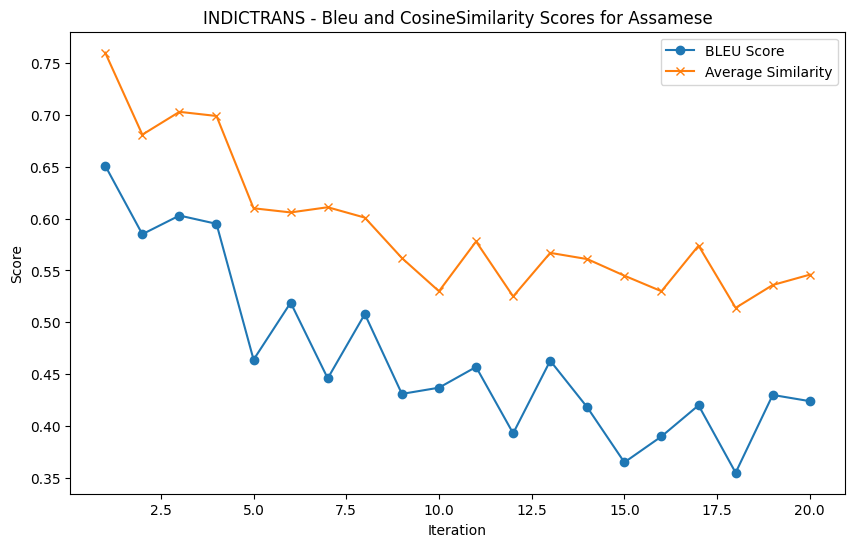

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, num_iterations + 1), as_bleu_scores, marker='o', linestyle='-', label='BLEU Score')
ax.plot(range(1, num_iterations + 1), as_similarity_values, marker='x', linestyle='-', label='Average Similarity')
ax.set_xlabel('Iteration')
ax.set_ylabel('Score')
ax.set_title('INDICTRANS - Bleu and CosineSimilarity Scores for Assamese')
ax.legend()

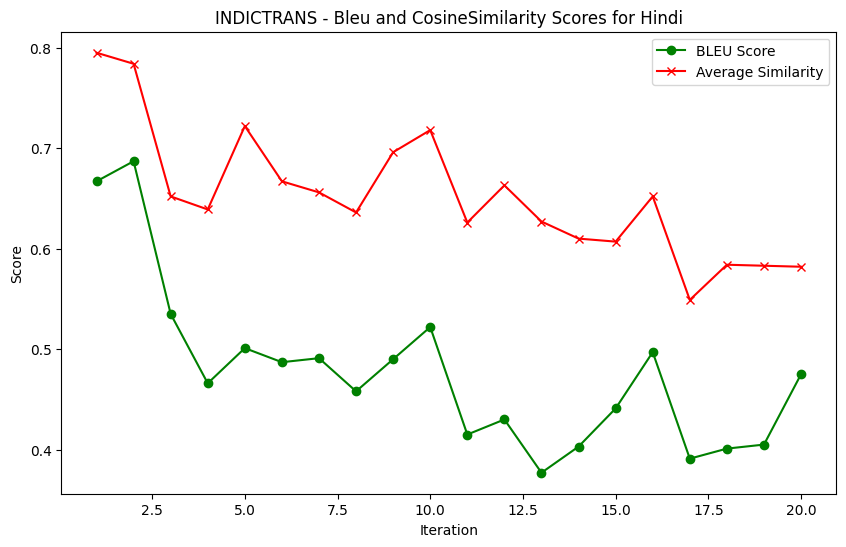

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, num_iterations + 1), hin_bleu_scores, marker='o', linestyle='-', label='BLEU Score', color='green')
ax.plot(range(1, num_iterations + 1), hin_similarity_values, marker='x', linestyle='-', label='Average Similarity', color='red')
ax.set_xlabel('Iteration')
ax.set_ylabel('Score')
ax.set_title('INDICTRANS - Bleu and CosineSimilarity Scores for Hindi')
ax.legend()